# Memory Information

In [1]:
import psutil
def get_size(bytes, suffix="B"):
    factor = 1024
    for unit in ["", "K", "M", "G", "T", "P"]:
        if bytes < factor:
            return f"{bytes:.2f}{unit}{suffix}"
        bytes /= factor
print("="*40, "Memory Information", "="*40)
svmem = psutil.virtual_memory()
print(f"Total: {get_size(svmem.total)}") ; print(f"Available: {get_size(svmem.available)}")
print(f"Used: {get_size(svmem.used)}") ; print(f"Percentage: {svmem.percent}%")

======================================== Memory Information ========================================
Total: 25.51GB
Available: 24.55GB
Used: 630.11MB
Percentage: 3.8%


# GPU Information

In [2]:
! nvidia-smi

Sun Apr  4 15:34:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    32W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import libraries and data

In [3]:
from sklearn.metrics import classification_report
from imutils import paths
from keras.applications import ResNet152V2 
from keras.applications import imagenet_utils
from keras.preprocessing.image import img_to_array,load_img
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD,RMSprop,Adam
from tensorflow.keras.layers import Flatten, Conv2D, AveragePooling2D, BatchNormalization, Dropout,Dense, Activation, Input, UpSampling2D, Add,GlobalAveragePooling2D
from tensorflow.keras.models import Model,Sequential
from keras.layers.core import Dense,Flatten,Dropout
import numpy as np
import random
import os
import keras
from tensorflow.keras.models import Sequential,Model, load_model
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import  ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras.models import load_model
import pickle
from keras.applications.vgg16 import VGG16
from numpy import expand_dims
from keras.models import Model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Define model

In [14]:
# import base module: BiT50
model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
module = hub.KerasLayer(model_url, trainable=True)
 
# build model
model = Sequential([
    module,
    tf.keras.layers.Dense(100, kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build(input_shape=(None,128,128,3))
 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              23500352  
_________________________________________________________________
dense (Dense)                (None, 100)               204900    
Total params: 23,705,252
Trainable params: 23,705,252
Non-trainable params: 0
_________________________________________________________________


In [15]:
BATCH_SIZE = 320
SCHEDULE_LENGTH = 5000
SCHEDULE_BOUNDARIES = [1000, 2000, 3000]
SCHEDULE_LENGTH = SCHEDULE_LENGTH * 512 / BATCH_SIZE
STEPS_PER_EPOCH = 10
RESIZE_TO = 160
CROP_TO = 128

# define optimiser and loss
lr = 0.002 * BATCH_SIZE / 512 

# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=SCHEDULE_BOUNDARIES, values=[lr, lr*0.1, lr*0.001, lr*0.0001])
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [16]:
# define callbacks
checkpoint_filepath = '/content/drive/MyDrive/Coursework 1/BiT fine-tune/bit50_cifar100_checkpoint_new'

train_callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=30,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath,
      save_weights_only=True,
      monitor='val_accuracy',
      save_best_only=True)
]

In [17]:
# compile model
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

# Data Preprocessing

In [5]:
# read data
ds, info = tfds.load(name='cifar100',
                     shuffle_files=True,
                     with_info=True)
num_examples = info.splits['train'].num_examples
NUM_CLASSES = 100

Shuffling and writing examples to /root/tensorflow_datasets/cifar100/3.0.2.incompleteAYJGTZ/cifar100-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cifar100/3.0.2.incompleteAYJGTZ/cifar100-test.tfrecord


Dataset cifar100 downloaded and prepared to /root/tensorflow_datasets/cifar100/3.0.2. Subsequent calls will reuse this data.


In [6]:
# split train, validation and test dataset
train_split = 0.8
num_train = int(train_split * num_examples)
ds_train = ds['train'].take(num_train)
ds_valid = ds['train'].skip(num_train)

DATASET_NUM_TRAIN_EXAMPLES = num_train

ds_test = ds['test']

In [9]:
BATCH_SIZE = 320
SCHEDULE_LENGTH = 5000
SCHEDULE_BOUNDARIES = [1000, 2000, 3000]
SCHEDULE_LENGTH = SCHEDULE_LENGTH * 512 / BATCH_SIZE
STEPS_PER_EPOCH = 10
RESIZE_TO = 160
CROP_TO = 128

def cast_to_tuple(features):
  return (features['image'], features['label'])
  
def preprocess_train(features):
  # Apply random crops and horizontal flips for all tasks 
  # except those for which cropping or flipping destroys the label semantics
  # (e.g. predict orientation of an object)
  features['image'] = tf.image.random_flip_left_right(features['image'])
  features['image'] = tf.image.resize(features['image'], [RESIZE_TO, RESIZE_TO])
  features['image'] = tf.image.random_crop(features['image'], [CROP_TO, CROP_TO, 3])
  features['image'] = tf.cast(features['image'], tf.float32) / 255.0
  return features

def preprocess_test(features):
  features['image'] = tf.image.resize(features['image'], [RESIZE_TO, RESIZE_TO])
  features['image'] = tf.cast(features['image'], tf.float32) / 255.0
  return features


In [10]:
pipeline_train = (ds_train
                  .shuffle(40000).cache() # Shuffle and keep data fit in memory
                  .repeat(int(SCHEDULE_LENGTH * BATCH_SIZE / DATASET_NUM_TRAIN_EXAMPLES * STEPS_PER_EPOCH) + 1) # repeat dataset_size / num_steps
                  .map(preprocess_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                  .map(cast_to_tuple)  # for keras model.fit
                  .batch(BATCH_SIZE)
                  .prefetch(tf.data.experimental.AUTOTUNE))

pipeline_valid = (ds_valid.map(preprocess_test, num_parallel_calls=1).cache()
                  .map(cast_to_tuple)  # for keras model.fit
                  .batch(BATCH_SIZE)
                  .prefetch(tf.data.experimental.AUTOTUNE))   # `prefetch` lets the dataset fetch batches in the background while the model is training

pipeline_test = (ds_test.map(preprocess_test, num_parallel_calls=1)
                  .map(cast_to_tuple)  # for keras model.fit
                  .batch(BATCH_SIZE)
                  .prefetch(2))

# Train model

In [ ]:
# # Feature extractor model
# history = model.fit(pipeline_train,
#                     batch_size=BATCH_SIZE,
#                     steps_per_epoch=STEPS_PER_EPOCH,
#                     callbacks= train_callbacks,
#                     epochs= 250,  
#                     validation_data=pipeline_valid)

Epoch 1/250
10/10 [==============================] - 74s 3s/step - loss: 9.2554 - accuracy: 0.0148 - val_loss: 4.8986 - val_accuracy: 0.0498
Epoch 2/250
10/10 [==============================] - 19s 2s/step - loss: 4.5775 - accuracy: 0.0710 - val_loss: 3.6030 - val_accuracy: 0.1862
Epoch 3/250
10/10 [==============================] - 19s 2s/step - loss: 3.3593 - accuracy: 0.2168 - val_loss: 2.6951 - val_accuracy: 0.3266
Epoch 4/250
10/10 [==============================] - 19s 2s/step - loss: 2.4631 - accuracy: 0.3654 - val_loss: 2.0969 - val_accuracy: 0.4476
Epoch 5/250
10/10 [==============================] - 19s 2s/step - loss: 2.0977 - accuracy: 0.4597 - val_loss: 1.7463 - val_accuracy: 0.5240
Epoch 6/250
10/10 [==============================] - 19s 2s/step - loss: 1.7201 - accuracy: 0.5325 - val_loss: 1.4574 - val_accuracy: 0.5902
Epoch 7/250
10/10 [==============================] - 19s 2s/step - loss: 1.4875 - accuracy: 0.6039 - val_loss: 1.2719 - val_accuracy: 0.6496
Epoch 8/250
1

# Save model

In [ ]:
# # save history into a pickle file
# history_path = "/content/drive/MyDrive/Coursework 1/BiT fine-tune/history_BiT50_cifar100_new.p"
# pickle.dump(history.history, open(history_path, "wb"))

# # save model
# save_path = "/content/drive/MyDrive/Coursework 1/BiT fine-tune/BiT50_cifar100_new.h5"
# model.save(save_path)

# Load model 

In [12]:
# load history
history = pickle.load(open("/content/drive/MyDrive/Coursework 1/BiT fine-tune/history_BiT50_cifar100_new.p", "rb"))

In [18]:
# load model weights
model.load_weights("/content/drive/MyDrive/Coursework 1/BiT fine-tune/BiT50_cifar100_new.h5")

# Evaluate model

In [19]:
# evaluate
model.evaluate(pipeline_test)

32/32 [==============================] - 52s 586ms/step - loss: 0.5230 - accuracy: 0.8684


[0.5295328497886658, 0.8654000163078308]

# Visualize

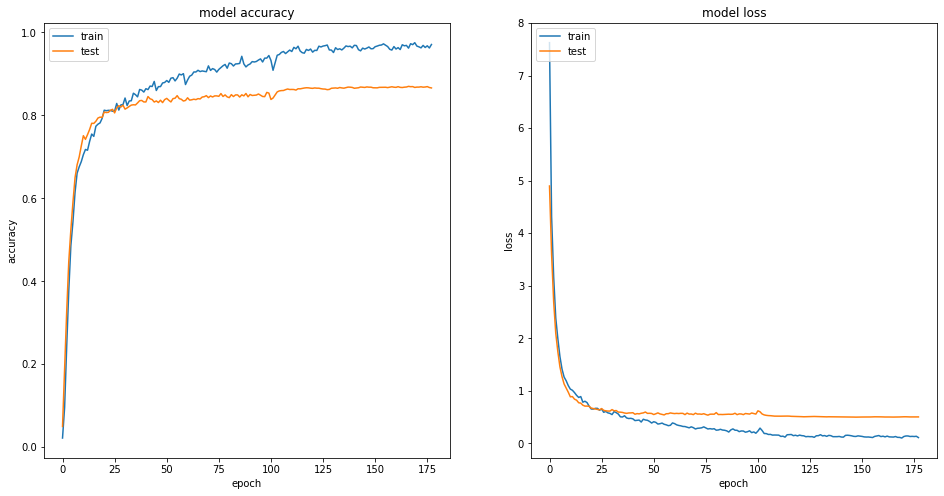

In [ ]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# summarize history for loss
plt.subplot(1,2,2)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

(7, 7, 3, 64)


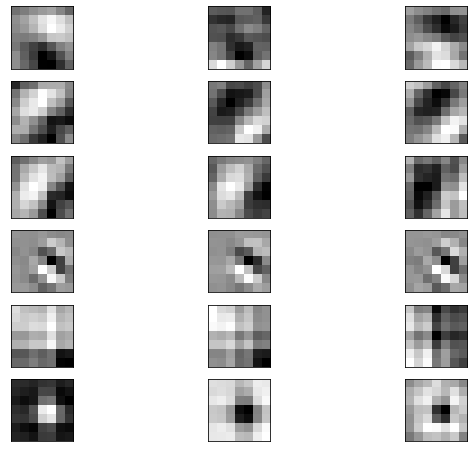

In [ ]:
# retrieve weights from the hidden layer
kernels = model.layers[0].get_weights()
filters = kernels[0]
print(filters.shape)
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# plot first few filters
n_filters, ix = 6, 1
plt.figure(figsize=(10,8))
for i in range(n_filters):
  # get the filter
  f = filters[:, :, :, i]
	# plot each channel separately
  for j in range(3):
		# specify subplot and turn of axis
    ax = plt.subplot(n_filters, 3, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    ix+=1
		# plot filter channel in grayscale
    plt.imshow(f[:, :, j], cmap='gray')
# show the figure
plt.show()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 224, 224, 64)      9472      
Total params: 9,472
Trainable params: 9,472
Non-trainable params: 0
_________________________________________________________________


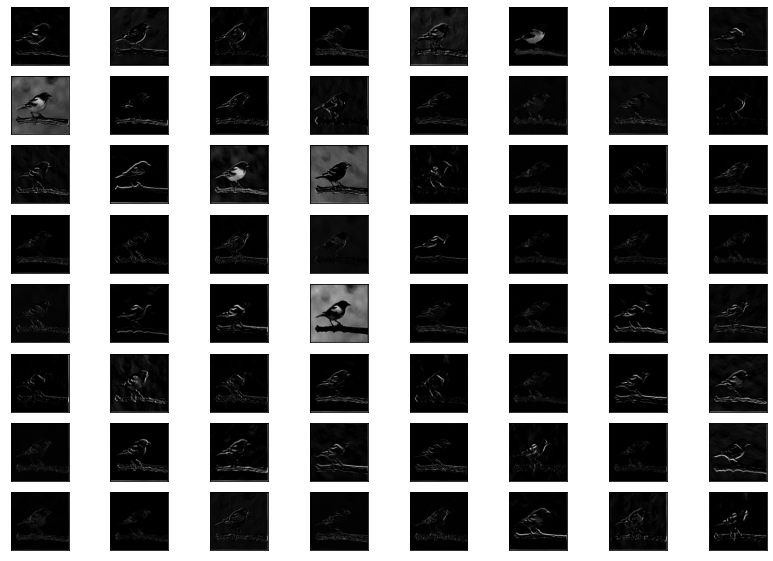

In [ ]:
def my_init(shape, dtype=None):
    return tf.convert_to_tensor(filters)
 
# redefine model to output right after the first hidden layer
inputs = Input(shape=(224, 224, 3))
outputs = Conv2D(64, (7,7), kernel_initializer=my_init,input_shape=(224,224,3), padding="same", activation='relu')(inputs)
model_ = Model(inputs=inputs, outputs=outputs)
model_.summary()
 
# load the image with the required shape
img = load_img('/content/drive/MyDrive/Coursework 1/BiT fine-tune/bird.png', target_size=(224, 224))
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# get feature map for first hidden layer
feature_maps = model_.predict(img)
# plot all 64 maps in an 8x8 squares
square = 8
ix = 1
plt.figure(figsize=(14,10))
for _ in range(square):
    for _ in range(square):
        # specify subplot and turn of axis
        ax = pyplot.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
        ix += 1
# show the figure
pyplot.show()